<a href="https://colab.research.google.com/github/lukemckinstry/fastai-projects/blob/master/ships_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation on aeriel ship images - based on CamVid example


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
#according to error
os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [0]:
DATA_DIR = Path('/content/data/ships_mini/')
DATA_DIR.mkdir(exist_ok=True, parents=True)

In [39]:
print( gpu_mem_get() )

GPUMemory(total=11441, free=10607, used=833)


### Get training Data From Drive

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')


#### Utilities for Managing Files on Google Drive

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records



### create folders and download data

In [6]:
train_file_name = 'ships_mini.zip'
label_file_name = 'train_ship_segmentations_v2.csv.zip'
codes_file_name = 'ship_codes.txt'

train_drive_file_id = get_file_id(train_file_name)
label_drive_file_id = get_file_id(label_file_name)
codes_drive_file_id = get_file_id(codes_file_name)



move_from_drive_to_disk([train_file_name], [DATA_DIR/train_file_name])
move_from_drive_to_disk([label_file_name], [DATA_DIR/label_file_name])
move_from_drive_to_disk([codes_file_name], [DATA_DIR/codes_file_name])

#!find '/content/' -type f -name \*.jpg -delete

Downloaded 72913034/72913034 bytes
Downloaded 18849010/18849010 bytes
Downloaded 13/13 bytes


In [0]:
!unzip -o {DATA_DIR}'/ships_mini.zip' -d {DATA_DIR}'/Train/'
!unzip -o {DATA_DIR}'/train_ship_segmentations_v2.csv.zip' -d {DATA_DIR}

In [8]:
!ls {DATA_DIR}'/Train/' | wc -l

500


In [0]:
path_img = str(DATA_DIR/'Train')

In [0]:
label_df_raw = pd.read_csv(f'{DATA_DIR}/train_ship_segmentations_v2.csv', low_memory=False )
label_df_raw = label_df_raw.replace(np.nan, '', regex=True)

In [0]:
pd.set_option("display.max_colwidth", 10000)

## Move some ship files to valid.txt 


In [0]:
ship_files = os.listdir(str(DATA_DIR) + '/Train')

In [0]:
valid_ships = ship_files[:30]

In [0]:
with open(str(DATA_DIR) + '/valid.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(valid_ships))

In [0]:
# for f in valid_ships:
#    os.remove(str(DATA_DIR) + '/Train/' + str(f))

In [15]:
#!ls {DATA_DIR}
!cat {DATA_DIR}/'valid.txt' | wc -l


29


### make dataframe of rle data for masks

In [16]:
#ship_files = os.listdir('data/ships_mini/Train')
def in_mini(f):
  return f['ImageId'] in ship_files
masks = label_df_raw[label_df_raw.apply(in_mini, axis=1)]
masks.shape, label_df_raw.shape
#test multi mask images
#l = list(masks['ImageId'])
#[i for i in l if l.count(i)>3]


((587, 2), (231723, 2))

In [17]:
#merge mask df on image id
masks = masks.groupby('ImageId')['EncodedPixels'].apply(lambda x: ' '.join(x)).reset_index()
masks.shape

(500, 2)

## Write masks to jpgs in /labels

In [0]:
!rm -rf {DATA_DIR}/label
!mkdir {DATA_DIR}/label
#!ls {DATA_DIR}/label | wc -l

In [0]:
dmasks = masks.to_dict()
for r in range( len( dmasks['ImageId'])):
  image_id = dmasks['ImageId'][r]
  filename = str( DATA_DIR/'label') + '/' + image_id
  rle_0 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels'].to_string(index=False)
  rle_mask = open_mask_rle( rle_0, [768,768])
  rle_mask = rle_mask.rotate(-90).flip_lr()
  rle_mask.save( DATA_DIR/'label/{}'.format(image_id) )


## Verify Mask imgs

In [20]:
verify_images(str(DATA_DIR) + '/label', delete=True, max_size=500)
verify_images(str(DATA_DIR) + '/Train', delete=True, max_size=500)


### Inspect Image, determine how to write masks from rle dataframe


In [21]:
fnames = get_image_files(path_img)
img_f = fnames[0]
img = open_image(img_f)
print( img.shape[2])
#img.show(figsize=(5,5))
#valid = fnames[-50:]
#len(fnames)
#[i.shape for i in fnames]

500


#### test rotation - target image


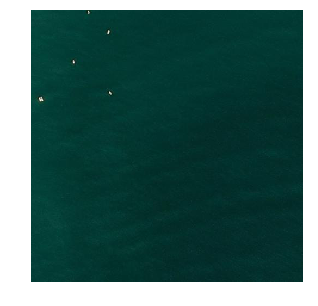

In [22]:
#img_0 = str(DATA_DIR/'Train') +'/'+ '00abc623a.jpg'
#img_0 = str(DATA_DIR/'Train') +'/'+ '002deeb16.jpg'

#multiple example to check

img_0 = str(DATA_DIR/'Train') +'/'+ '0041d7084.jpg'

img_0 = open_image(img_0)
img_0.show(figsize=(5,5))

#### test rotation, mask

tensor(0)


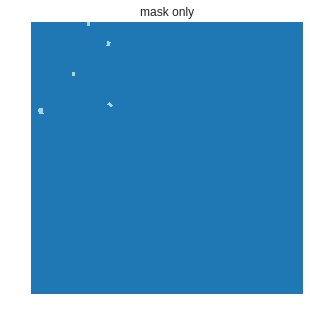

In [23]:
#rle_0 = masks.query('ImageId=="00abc623a.jpg"')['EncodedPixels'].to_string(index=False)
#rle_0 = masks.query('ImageId=="002deeb16.jpg"')['EncodedPixels'].to_string(index=False)
#rle_1 = masks.query('ImageId=="00003e153.jpg"')['EncodedPixels'].to_string(index=False)

#multiple example to check
rle_0 = masks.query('ImageId=="0041d7084.jpg"')['EncodedPixels'].to_string(index=False)


rle_0 = open_mask_rle( rle_0, [768,768])
rle_0 = rle_0.rotate(-90).flip_lr()
print( rle_0.data[0][0][78] )
rle_0.show(figsize=(5,5), alpha=1, title='mask only')


In [0]:
def get_y_fn(y):
    return str( DATA_DIR/'label/') + '/'+ str(y).replace('/content/data/ships_mini/Train/','') 

In [25]:
mask = open_mask(get_y_fn(img_f))
#mask.shape[1:]
#mask.show(figsize=(5,5), alpha=1)
src_size = np.array(mask.shape[1:])

np.array(mask.shape[1:])

src_size

#img_0.show(figsize=(5,5), y=rle_0, title='masked')


array([500, 500])

In [26]:
#codes = np.array(['NotShip', 'Ship'])
codes = np.loadtxt(DATA_DIR/'ship_codes.txt', dtype=str); codes

array(['NotShip', 'Ship'], dtype='<U7')

## Data - load w/ datablock api

In [0]:

size = src_size//8
size

# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")
bs=1

In [28]:
size

array([62, 62])

In [29]:
!less {path_img}/'../valid.txt'

00949c7e5.jpg
003e929b2.jpg
008127d89.jpg
006afd8f9.jpg
005d6d2f2.jpg
00a1aab5b.jpg
008be8252.jpg
005a782bb.jpg
00387da9b.jpg
008a1bdb4.jpg
003e2c95d.jpg
001b9e692.jpg
004f97cfb.jpg
003850cde.jpg
006a5835a.jpg
0058896c8.jpg
00862fc1d.jpg
00885c45f.jpg
0057b03e2.jpg
0056cff59.jpg
00717ce00.jpg
00286e8b9.jpg
002c62c03.jpg
>8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
         .databunch(bs=bs)
         .normalize(imagenet_stats))

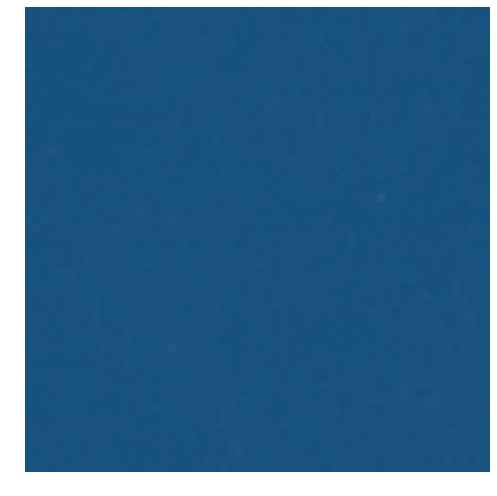

In [32]:
 data.show_batch(2, figsize=(10,7))

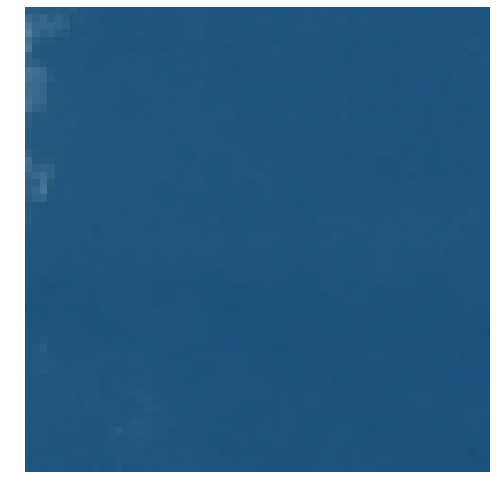

In [33]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
#name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']
#void_code

def acc_ships(input, target):
    print( 'acc,  ' )
    print( 'input original shape ', input.shape )
    print( 'target before squeeze ', target.shape )
    target = target.squeeze(1)
    print( 'target after squeeze ', target.shape )
    
    #mask = target != void_code
    #mask = target
    print( 'input argmax dim=1 shape ', input.argmax(dim=1).shape )
    print( 'final output acc_camvid shape ', (input.argmax(dim=1)==target).float().mean() )
    return (input.argmax(dim=1)==target).float().mean()

In [0]:
#metrics=acc_ships
metrics=accuracy

In [0]:
wd=1e-2

In [36]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 92836165.23it/s]


In [38]:
lr_find(learn)

RuntimeError: ignored

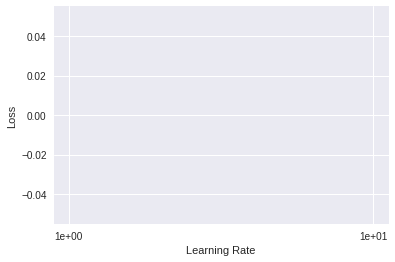

In [0]:
learn.recorder.plot()

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

RuntimeError: ignored

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

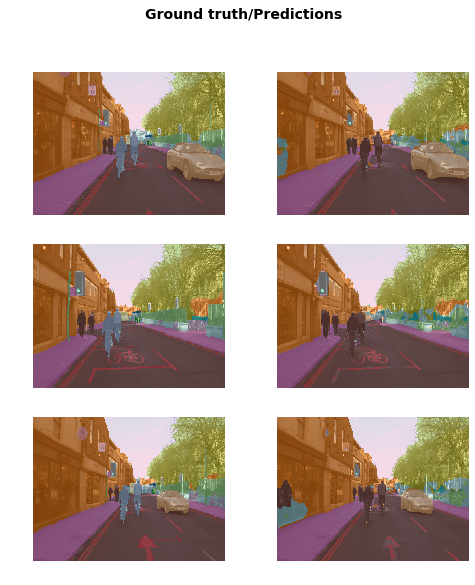

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.389135,0.334715,0.896700
2,0.377873,0.324080,0.900284
3,0.369020,0.325073,0.904146
4,0.355022,0.308820,0.912556
5,0.351138,0.313001,0.909351
6,0.347777,0.285509,0.920183
7,0.338683,0.306076,0.909899
8,0.318913,0.303712,0.915792
9,0.312038,0.276126,0.920137
10,0.311217,0.276649,0.925244


In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=3

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


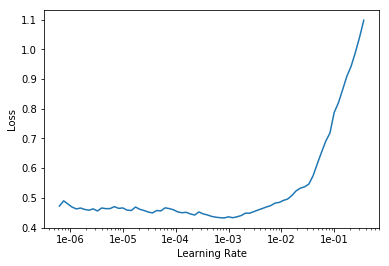

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

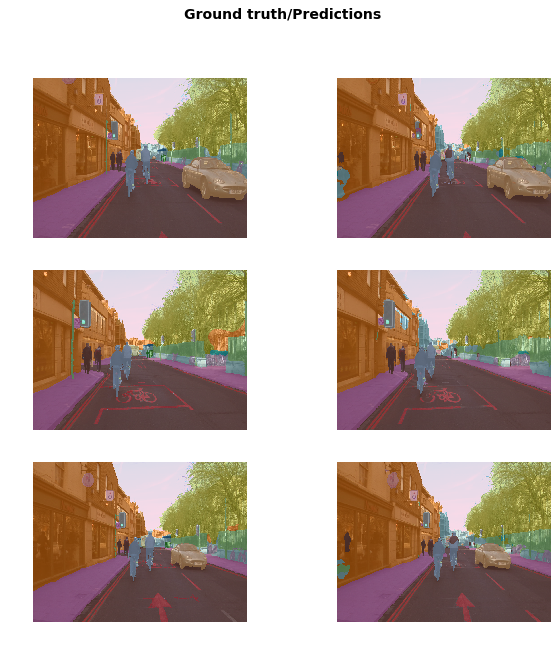

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## fin